https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

In [1]:
# download the dataset
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# unzip it
!tar -zxf /content/aclImdb_v1.tar.gz

In [ ]:
!pip install -Uq git+https://github.com/huggingface/transformers.git
!pip install -q torch_snippets

In [11]:
import os
import io
from tqdm.notebook import tqdm

import torch
from torch_snippets import *
from torch.utils.data import Dataset, DataLoader
from transformers import (TrainingArguments, Trainer,
                          GPT2Config, GPT2Tokenizer,
                          get_linear_schedule_with_warmup)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "gpt2"
labels_ids = {"neg": 0, "pos": 1}
n_labels = len(labels_ids)
num_epochs = 4
batch_size = 32
max_length = 60

[06/29/23 11:30:06] WARNING  Unable to load torch and dependent libraries from                ]8;id=112931;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py\loader.py]8;;\:]8;id=879234;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py#<module>:98\<module>:98]8;;\
                             torch-snippets.                                                                       
                             Functionalities might be limited. pip install lovely-tensors in                       
                             case there are torch related errors                                                   

In [13]:
import io

In [14]:
print("🔥 Loading tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
print("Done!")
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

class MyDataset(Dataset):
  def __init__(self, path, tokenizer, max_length=60):
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.labels_encoder = {"neg": 0, "pos": 1}

    self.texts = []
    self.labels = []
    print("📖 Loading Data...")
    for label in ["pos", "neg"]:
      sentiment_path = os.path.join(path, label)

      files_names = os.listdir(sentiment_path)
      for file_name in tqdm.tqdm(files_names, desc=f"{label} files"):
        file_path = os.path.join(sentiment_path, file_name)
        content = io.open(file_path, mode="r", encoding="utf-8").read()
        self.texts.append(content)
        self.labels.append(label)
    self.n_examples = len(self.labels)
    print("Done!")

  def __len__(self):
    return self.n_examples

  def __getitem__(self, index):
    return {"text": self.texts[index],
            "label": self.labels[index]}

  def collate_fn(self, batch):
    texts = [seq["text"] for seq in batch]
    labels = [seq["label"] for seq in batch]

    labels = [self.labels_encoder[label] for label in labels]
    inputs = self.tokenizer(text=texts,
                            padding=True,
                            truncation=True,
                            max_length=self.max_length,
                            return_tensors="pt")
    inputs.update({'labels':torch.tensor(labels)})

    return inputs

tr_ds = MyDataset(path="/content/aclImdb/train", tokenizer=tokenizer)
val_ds = MyDataset(path="/content/aclImdb/test", tokenizer=tokenizer)

tr_dl = DataLoader(tr_ds, shuffle=True, batch_size=batch_size, collate_fn=tr_ds.collate_fn)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=batch_size, collate_fn=val_ds.collate_fn)

🔥 Loading tokenizer...

Done!

📖 Loading Data...

neg files: 100%|██████████| 12500/12500 [00:00<00:00, 28087.63it/s]


Done!

📖 Loading Data...

neg files: 100%|██████████| 12500/12500 [00:00<00:00, 27497.33it/s]


Done!

In [19]:
dl = DataLoader(ds, batch_size=2, collate_fn=ds.collate_fn)
batch = next(iter(dl))

Model

In [15]:
from transformers.models.gpt2.modeling_gpt2 import GPT2ForSequenceClassification
def train_batch(model, batch, optimizer, scheduler):
  batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
  model.train()
  optimizer.zero_grad()
  outputs = model(**batch)
  loss, logits = outputs[:2]
  preds = logits.argmax(-1).flatten()
  labels = batch["labels"]
  acc = (preds == labels).float().mean()

  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

  scheduler.step()
  optimizer.step()

  return loss.item(), acc

@torch.no_grad()
def validate_batch(model, batch):
  batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
  model.eval()
  outputs = model(**batch)
  loss, logits = outputs[:2]
  preds = logits.argmax(-1).flatten()
  labels = batch["labels"]
  acc = (preds == labels).float().mean()
  return loss.item(), acc

print("🤖 Loading the model...")
model_config = GPT2Config.from_pretrained(model_name_or_path,
                                          num_labels=n_labels)
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path,
                                                      config=model_config)
print("Done!")
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)
total_steps = len(tr_dl) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

print("🧑‍🏫 Start the training...")
log = Report(num_epochs)
for e in range(num_epochs):
  N = len(tr_dl)
  for i, batch in enumerate(tr_dl):
    loss, acc = train_batch(model, batch, optimizer, scheduler)
    log.record(e+(i+1)/N, trn_loss=loss, trn_acc = acc, end="\r")
  N = len(val_dl)
  for i, batch in enumerate(val_dl):
    loss, acc = validate_batch(model, batch)
    log.record(e+(i+1)/N, val_loss=loss, val_acc = acc, end="\r")

  log.report_avgs(e+1)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


EPOCH: 1.000  trn_loss: 0.560  val_loss: 0.387  val_acc: 0.817  trn_acc: 0.752  (473.49s - 1420.48s remaining)
EPOCH: 2.000  trn_loss: 0.369  val_loss: 0.379  val_acc: 0.824  trn_acc: 0.833  (921.21s - 921.21s remaining)
EPOCH: 3.000  trn_loss: 0.315  val_loss: 0.395  val_acc: 0.827  trn_acc: 0.864  (1366.31s - 455.44s remaining)
EPOCH: 4.000  trn_loss: 0.276  val_loss: 0.404  val_acc: 0.831  trn_acc: 0.882  (1810.92s - 0.00s remaining)


100%|██████████| 105/105 [00:00<00:00, 402.82it/s]


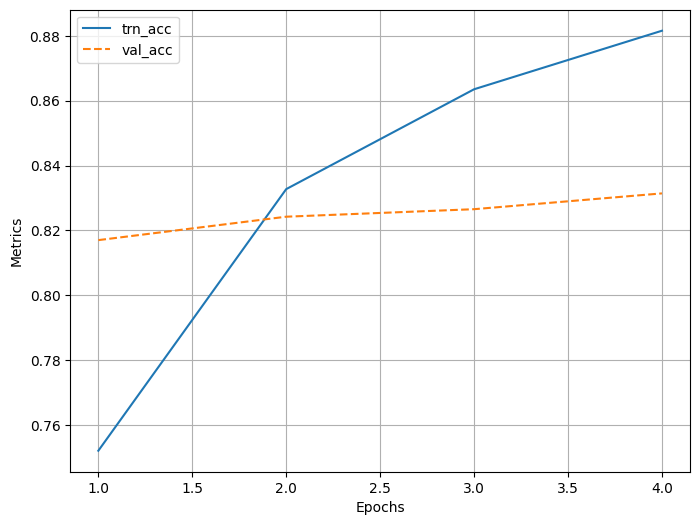

In [17]:
log.plot_epochs(['trn_acc', 'val_acc'])

100%|██████████| 105/105 [00:00<00:00, 767.97it/s]


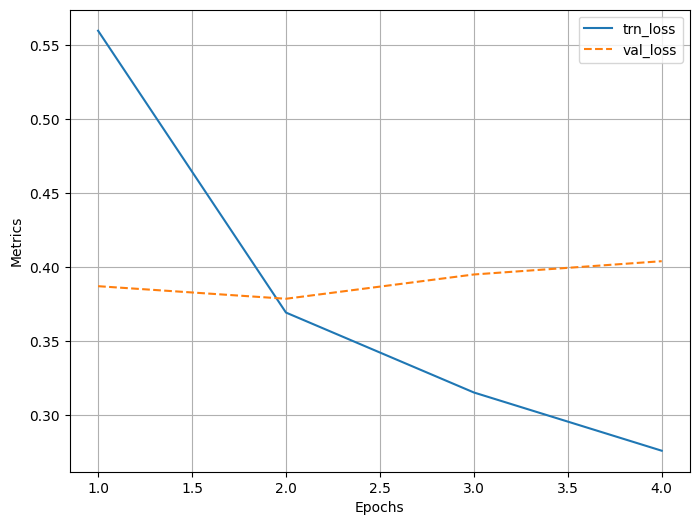

In [16]:
log.plot_epochs(['trn_loss', 'val_loss'])